# MLPC predictions per class


2023-11-23

version_1 to be checked by John 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
from tensorflow import keras

sklearn.set_config(transform_output="pandas")

2023-11-27 17:18:37.508253: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 17:18:37.547602: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 17:18:37.547630: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 17:18:37.547653: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 17:18:37.555469: I tensorflow/core/platform/cpu_feature_g

In [2]:
keras.backend.clear_session()
keras.utils.set_random_seed(2)

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin


def select_samples(name, n=None, sample_names_to_check=None):
    index_list = []
    for index, sample_description in enumerate(sample_names_to_check):
        if name in sample_description and len(name) == len(sample_description):
            index_list.append(index)

    return index_list[:n]


def get_classes_batches(data):
    classes = []
    batches = []
    for name in data.index:
        parts = name.split("_")
        if name.startswith("BA"):
            batches.append("7128_old")
            classes.append(parts[-2])
        else:
            classes.append(parts[-2])
            batches.append(parts[1])

    classes = pd.Series(classes, name="class", index=data.index)
    batches = pd.Series(batches, name="batch", index=data.index)

    return classes, batches


class LibraryLengthNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Normalise the gene counts to the library size
        X = X.apply(lambda x: (x / (x.sum() if x.sum() != 0 else 1)) * 1000000)
        return X

In [4]:
pd.set_option("display.max_columns", 20)
pd.set_option("display.max_rows", 200)
pd.set_option("display.precision", 5)
pd.set_option("display.max_seq_items", 50)

In [5]:
file_name = "/home/t.afanasyeva/MATseq/notebooks/gene_counts_7128_61_training.csv"
training_data = pd.read_csv(file_name)

training_labels = training_data["class"]
training_features = training_data.drop(columns=["sample", "class"])

In [6]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
)
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import PowerTransformer

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

forest = ExtraTreesClassifier(n_estimators=250, max_depth=5, random_state=1)


feature_transformer = Pipeline(
    [
        (
            "drop_duplicates",
            DropDuplicateFeatures(),
        ),
        ("drop_constant_feature", DropConstantFeatures(tol=0.50)),
        ("normalise_for_library_size", LibraryLengthNormalizer()),
        ("cap_outliers", Winsorizer(capping_method="gaussian", tail="right", fold=3)),
    ]
)

feature_selector = Pipeline(
    [
        ("select_k_best", SelectKBest(chi2, k=1000)),
        (
            "trasnform_and_scale",
            PowerTransformer(method="yeo-johnson", standardize=True),
        ),
        ("select_forest", SelectFromModel(forest, threshold=0.001)),
    ]
)

In [7]:
from sklearn.neighbors import LocalOutlierFactor

features = training_features
labels = training_labels

clf = LocalOutlierFactor(n_neighbors=4)
outliers = clf.fit_predict(features)
mask = [outlier != -1 for outlier in outliers]
features = features[mask]
labels = labels[mask]

In [8]:
X_train = features.reset_index(drop=True)
y_train = labels.reset_index(drop=True)

X_train = feature_transformer.fit_transform(X_train)
X_train = feature_selector.fit_transform(X_train, y_train)

In [9]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy="not majority", k_neighbors=1)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train = le.fit_transform(y_train)

In [11]:
# from joblib import load

# filepath_mlpc = "/home/t.afanasyeva/MATseq/models/MLPC/mlpc_ver2.joblib"

# mlpc = load(filepath_mlpc)

In [12]:
# from keras.saving import load_model

# filepath_nn = (
#     "/home/t.afanasyeva/MATseq/models/NN/MATseq_NN_multiclass_classifier_v0.3.keras"
# )

# nn = load_model(filepath_nn, custom_objects=None, compile=True)

In [27]:
# Defines the best parameters for NN
config = {
    "l1": 1200,
    "l2": 900,
    "l3": 450,
    "l4": 270,
    "batch_size": 8,
    "activation": "elu",
    "epochs": 400,
    "learning_rate": 0.001,
    "loss": "categorical_crossentropy",
    "dropout_rate1": 0.5,
    "dropout_rate2": 0.7,
    "dropout_rate3": 0.8,
    "dropout_rate4": 0.9,
}

In [14]:
earlystopper = keras.callbacks.EarlyStopping(
    monitor="loss", patience=80, verbose=1, mode="min", restore_best_weights=True
)

In [15]:
from tensorflow.keras.utils import to_categorical

y_train_nn = to_categorical(y_train)
num_classes = y_train_nn.shape[1]
num_classes

8

In [28]:
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.constraints import MaxNorm


def nn():
    with tf.device("/GPU:0"):
        batch_size = config.get("batch_size")
        activation = config.get("activation")
        epochs = config.get("epochs")
        learning_rate = config.get("learning_rate")
        loss = config.get("loss")
        l1 = config.get("l1")
        l2 = config.get("l2")
        l3 = config.get("l3")
        l4 = config.get("l4")

        dropout_rate1 = config.get("dropout_rate1")
        dropout_rate2 = config.get("dropout_rate2")
        dropout_rate3 = config.get("dropout_rate3")
        dropout_rate4 = config.get("dropout_rate4")
        batch_size = config.get("batch_size")
        epochs = config.get("epochs")

        inputs = keras.Input(shape=X_train.shape[1])
        x = keras.layers.UnitNormalization()(inputs)

        x = keras.layers.Dense(
            l1,
            activation=activation,
            kernel_constraint=MaxNorm(3),
            kernel_initializer=HeUniform(),
        )(x)
        x = keras.layers.Dropout(dropout_rate1)(x)

        x = keras.layers.Dense(
            l2,
            activation=activation,
            kernel_constraint=MaxNorm(3),
            kernel_initializer=HeUniform(),
        )(x)
        x = keras.layers.Dropout(dropout_rate2)(x)

        x = keras.layers.Dense(
            l3,
            activation=activation,
            kernel_constraint=MaxNorm(3),
            kernel_initializer=HeUniform(),
        )(x)
        x = keras.layers.Dropout(dropout_rate3)(x)

        x = keras.layers.Dense(
            l4,
            activation=activation,
            kernel_constraint=MaxNorm(3),
            kernel_initializer=HeUniform(),
        )(x)
        x = keras.layers.Dropout(dropout_rate4)(x)

        outputs = keras.layers.Dense(8, activation="softmax")(x)

        model = keras.Model(
            inputs=inputs,
            outputs=outputs,
            name="MATseq_NN_multiclass_classifier_v0.3",
        )

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=loss,
            metrics=[
                "accuracy",
                keras.metrics.AUC(name="auc"),
            ],
        )

        model.fit(
            X_train,
            y_train_nn,
            epochs=epochs,
            batch_size=batch_size,
            verbose=True,
            callbacks=[earlystopper],
        )

        return model

In [29]:
nn = nn()

Epoch 1/400


15/15 [==============================] - 2s 7ms/step - loss: 5.9606 - accuracy: 0.1833 - auc: 0.5363
Epoch 2/400
15/15 [==============================] - 0s 6ms/step - loss: 6.2992 - accuracy: 0.2083 - auc: 0.5659
Epoch 3/400
15/15 [==============================] - 0s 6ms/step - loss: 7.4738 - accuracy: 0.1667 - auc: 0.5532
Epoch 4/400
15/15 [==============================] - 0s 6ms/step - loss: 6.8906 - accuracy: 0.2000 - auc: 0.5696
Epoch 5/400
15/15 [==============================] - 0s 6ms/step - loss: 7.6584 - accuracy: 0.1583 - auc: 0.5439
Epoch 6/400
15/15 [==============================] - 0s 7ms/step - loss: 5.8736 - accuracy: 0.2667 - auc: 0.6106
Epoch 7/400
15/15 [==============================] - 0s 6ms/step - loss: 6.1481 - accuracy: 0.2500 - auc: 0.6051
Epoch 8/400
15/15 [==============================] - 0s 7ms/step - loss: 5.2736 - accuracy: 0.3083 - auc: 0.6766
Epoch 9/400
15/15 [==============================] - 0s 6ms/step - loss: 4.4648 - accuracy: 0.3167 - auc: 0.

In [18]:
# Defines the best parameters for MLPC
params = {
    "activation": "relu",
    "alpha": 0.0001,
    "batch_size": "auto",
    "beta_1": 0.9,
    "beta_2": 0.999,
    "early_stopping": False,
    "epsilon": 1e-08,
    "hidden_layer_sizes": (100,),
    "learning_rate": "constant",
    "learning_rate_init": 0.001,
    "max_fun": 15000,
    "max_iter": 600,
    "momentum": 0.9,
    "n_iter_no_change": 10,
    "nesterovs_momentum": True,
    "power_t": 0.5,
    "random_state": 0,
    "shuffle": True,
    "solver": "adam",
    "tol": 0.0001,
    "validation_fraction": 0.1,
    "verbose": False,
    "warm_start": False,
}

In [19]:
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

mlpc = MLPClassifier(**params)
bst = XGBClassifier(n_estimators=75, max_depth=20, learning_rate=0.001)

In [20]:
models_to_train = {
    "MLPClassifier": mlpc,
    "XGBClassifier": bst,
}

In [21]:
for name, model in models_to_train.items():
    model.fit(X_train, y_train)

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dt

In [22]:
models_to_test = {
    "MLPClassifier": mlpc,
    "XGBClassifier": bst,
    "NeuralNetwork": nn,
}

In [23]:
le.classes_

array(['CL-307', 'CRX-527', 'Fla-PA', 'Fla-St', 'IMDM', 'LPS', 'Pam3',
       'R848'], dtype=object)

In [24]:
classes_to_check = le.classes_

In [25]:
file_name = "/home/t.afanasyeva/MATseq/notebooks/gene_counts_143_test.csv"
test_features = pd.read_csv(file_name)

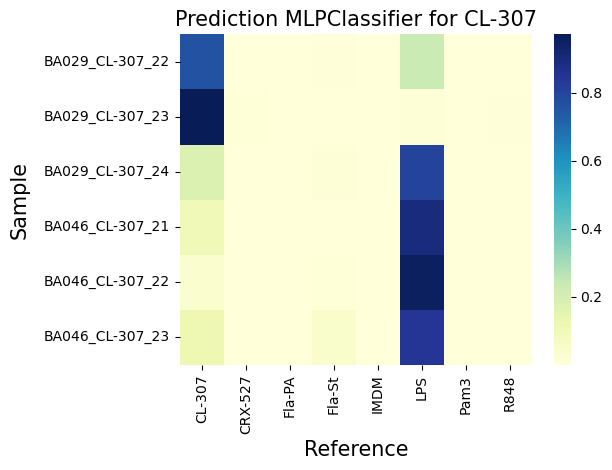

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dt

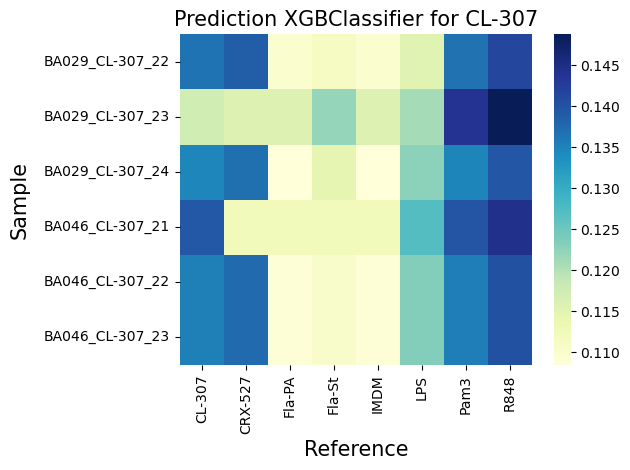

1/1 [==============================] - 0s 88ms/step


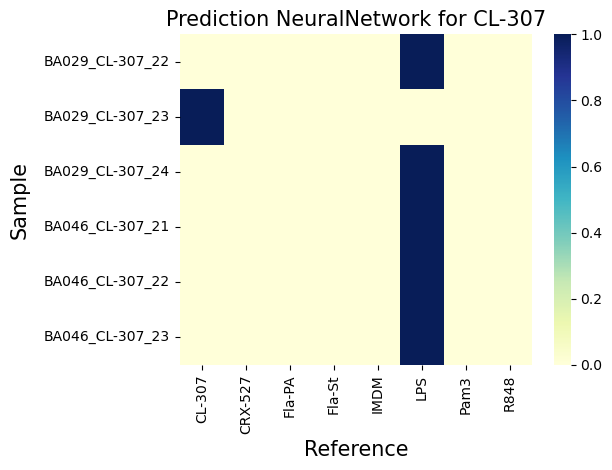

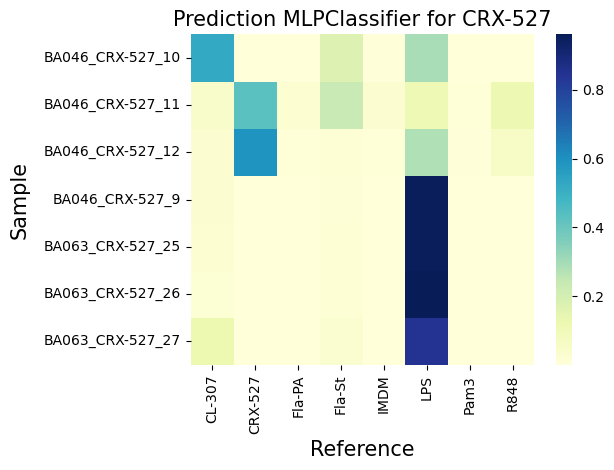

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dt

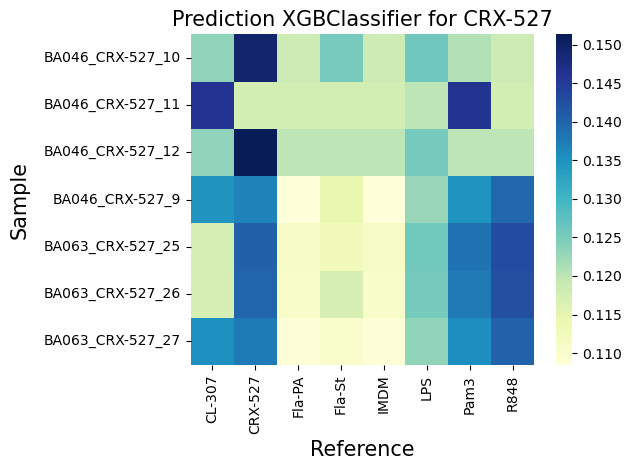

1/1 [==============================] - 0s 19ms/step


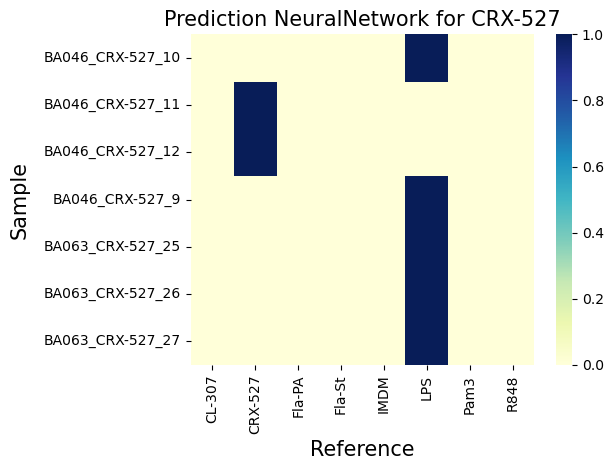

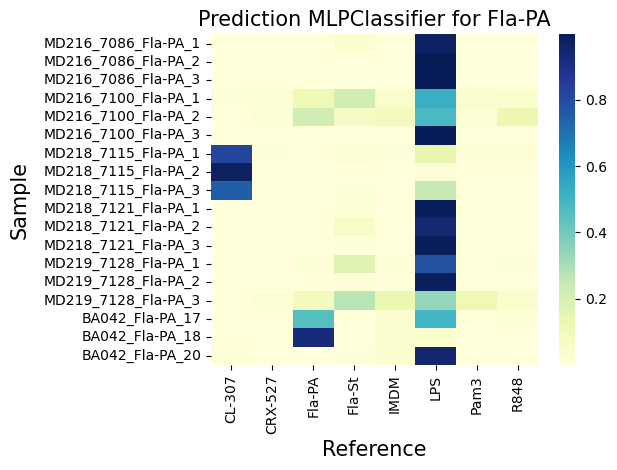

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dt

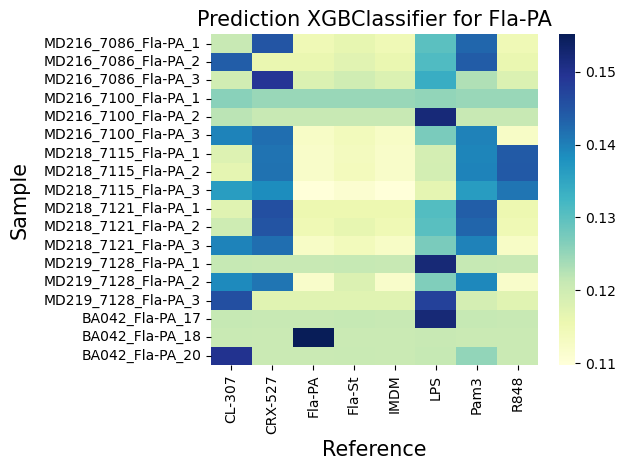

1/1 [==============================] - 0s 25ms/step


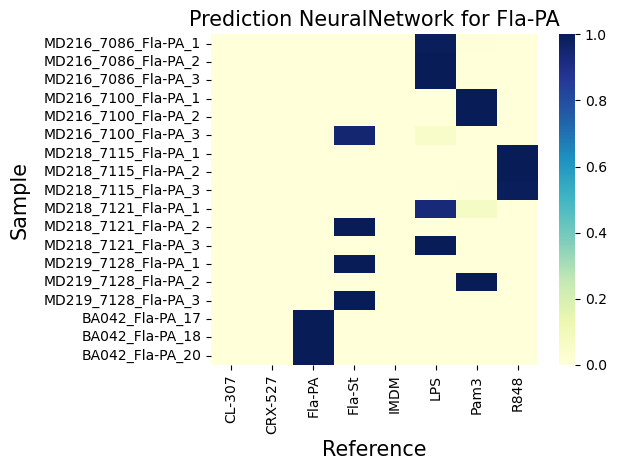

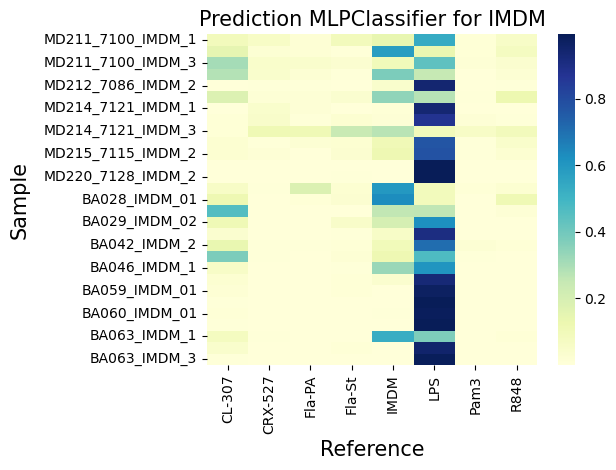

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dt

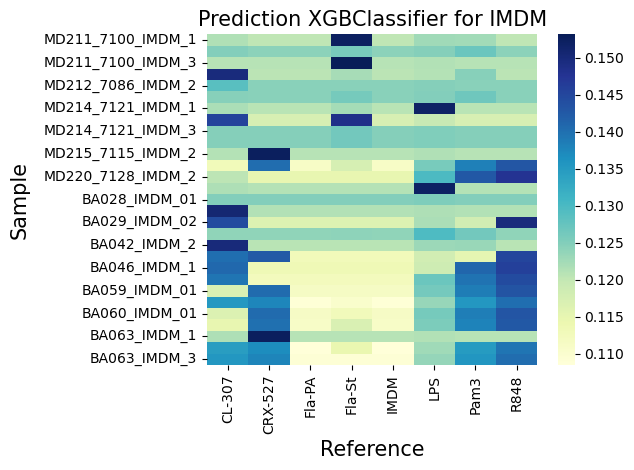

1/1 [==============================] - 0s 20ms/step


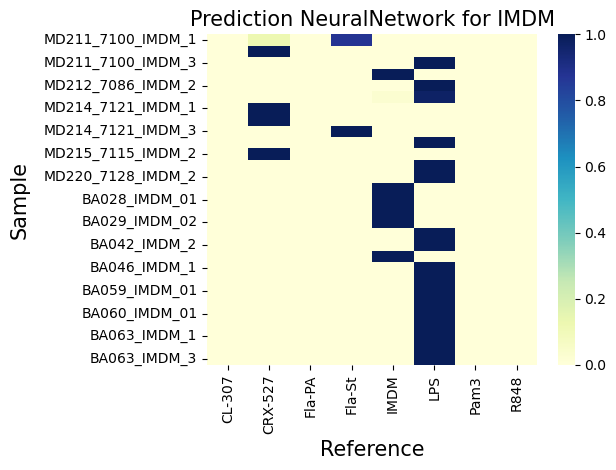

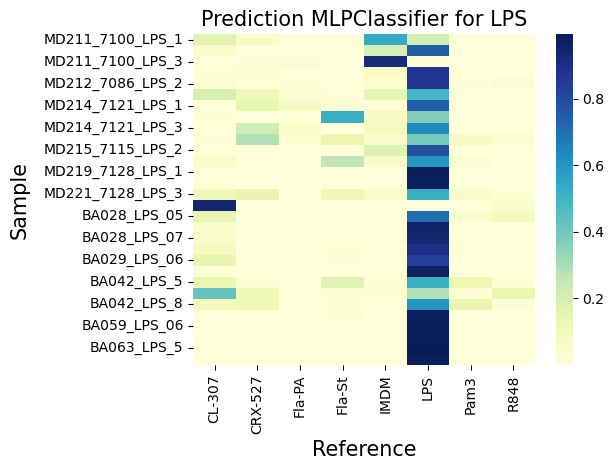

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dt

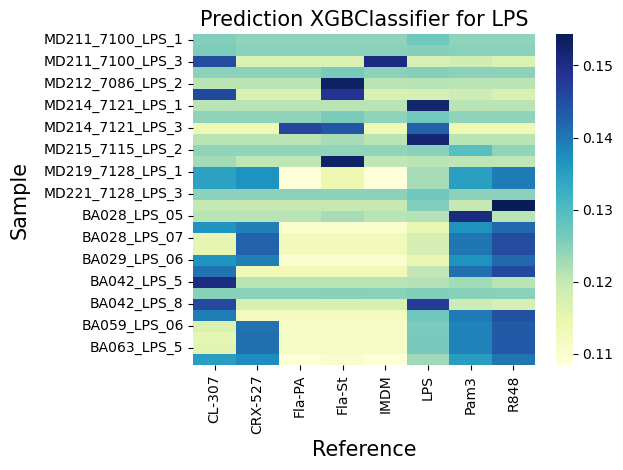

1/1 [==============================] - 0s 19ms/step


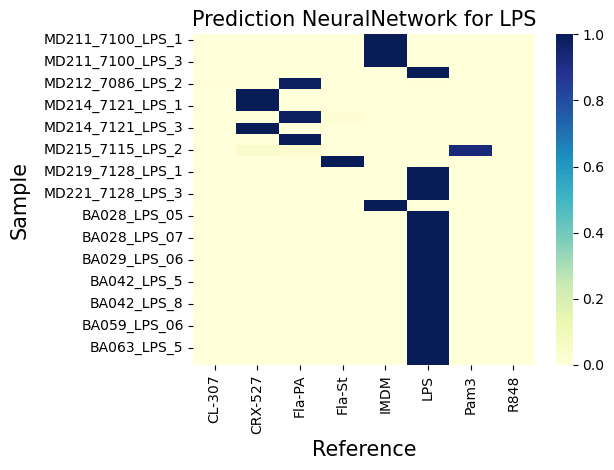

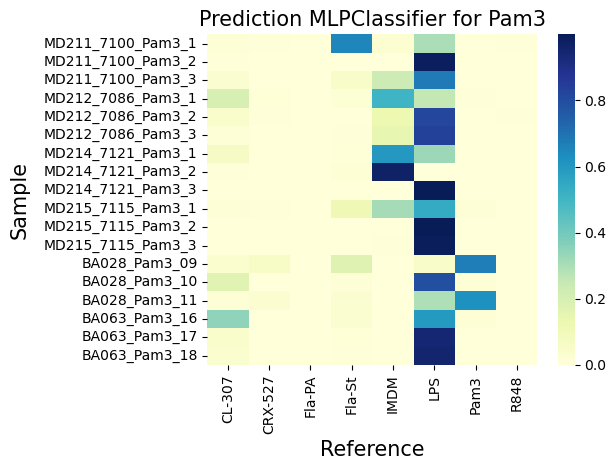

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dt

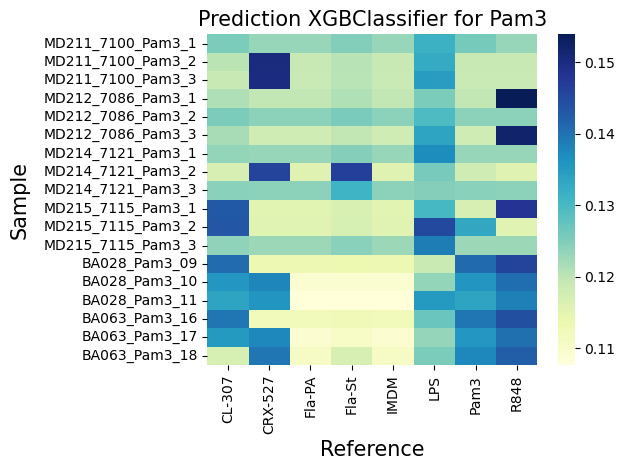

1/1 [==============================] - 0s 19ms/step


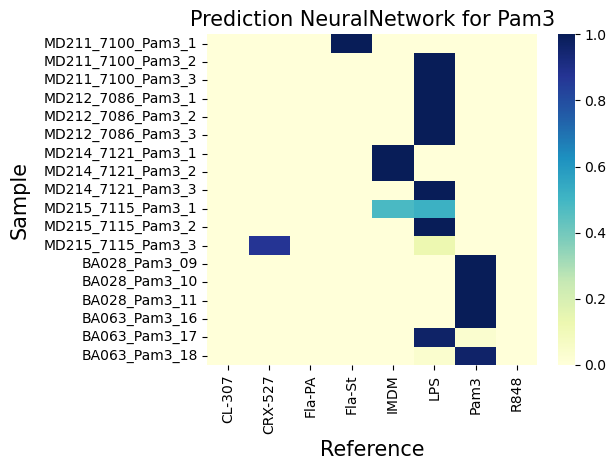

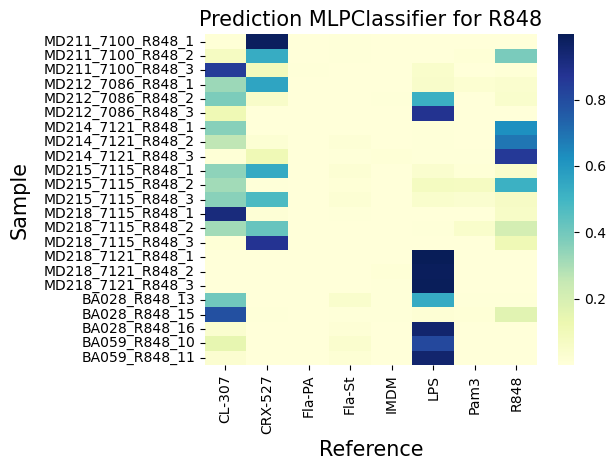

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/xgboost/data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dt

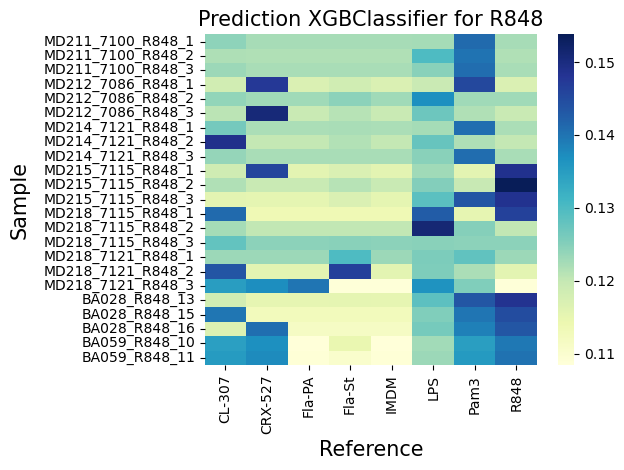

1/1 [==============================] - 0s 20ms/step


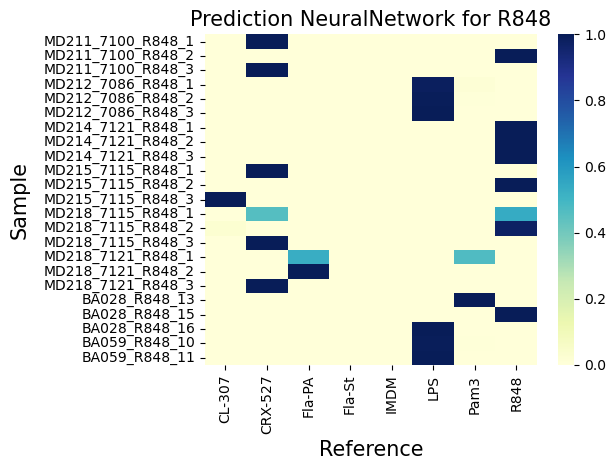

In [26]:
for my_class in classes_to_check:
    test_features_subset = test_features[test_features["class"] == my_class]

    if test_features_subset.empty is False:
        y_test = test_features_subset["sample"]

        test_features_subset = test_features_subset.drop(["class", "sample"], axis=1)

        X_test = test_features_subset
        X_test = feature_transformer.transform(X_test)
        X_test = feature_selector.transform(X_test)

        for name, model in models_to_test.items():
            if name == "NeuralNetwork":
                test_pred = pd.DataFrame(
                    model.predict(X_test),
                    columns=list(le.classes_),
                    index=list(y_test),
                )
            else:
                test_pred = pd.DataFrame(
                    model.predict_proba(X_test),
                    columns=list(le.classes_),
                    index=list(y_test),
                )

            heat = sns.heatmap(test_pred, cmap="YlGnBu")
            # Adjust layout for the plot
            heat.set_title(f"Prediction {name} for {my_class}", fontsize=15)
            heat.set_xlabel("Reference", fontsize=15)
            heat.set_ylabel("Sample", fontsize=15, labelpad=10)

            # plt.savefig(f"{name}_{my_class}_predictions.png", bbox_inches="tight")
            plt.tight_layout()
            plt.show()